In [26]:
import torch
from reasoning_from_scratch.ch02 import get_device
from reasoning_from_scratch.ch02_ex import generate_text_basic_stream_cache
from reasoning_from_scratch.ch03 import load_model_and_tokenizer, generate_text_stream_concat
from reasoning_from_scratch.ch03 import render_prompt, extract_final_candidate, grade_answer, eta_progress_message
from IPython.display import Latex, display, Math


In [43]:
device = 'cpu' #for benchmark results

model, tokenizer = load_model_and_tokenizer('base', device, use_compile=False, local_dir='../models/qwen3_base')

✓ ..\models\qwen3_base\qwen3-0.6B-base.pth already up-to-date


d:\PersonalStudy\OTHER_COURSES\BOOKS\General_Theory\LLM\LLM_second_course\REASONING_MODELS\Reasoning-Model\venv\Lib\site-packages\reasoning_from_scratch\ch03.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

In [8]:
raw_prompt = """ 
Half the value of $3x-9$ is $x+37$. 
What is the value of $x$?
"""

prompt = render_prompt(raw_prompt)
print(prompt)

You are a helpful math assistant.
Answer the question and write the final result on a new line as:
\boxed{ANSWER}

Question:
 
Half the value of $3x-9$ is $x+37$. 
What is the value of $x$?


Answer:


In [12]:
def generate_text_stream_concat_flex(model, tokenizer, prompt, device, max_new_tokens = 1024, verbose=False, generate_func=None, **generate_kwargs):

    if generate_func is None:
        generate_func = generate_text_basic_stream_cache
    
    input_ids = torch.tensor(tokenizer.encode(prompt), device=device).unsqueeze(0)

    generated_ids = []
    for token in generate_func(model, input_ids, max_new_tokens, eos_token_id=tokenizer.eos_token_id, **generate_kwargs):

        next_token_id = token.squeeze(0)
        generated_ids.append(next_token_id.item())

        if verbose:
            print(tokenizer.decode([next_token_id]), end='', flush=True)
    
    return tokenizer.decode(generated_ids)

In [17]:
response = generate_text_stream_concat_flex(model, tokenizer, prompt, device, verbose=True, generate_func=generate_text_basic_stream_cache)

 \boxed{20}

The result is wrong, we can try some **inference-rime scaling** techniques to address this problem

# Chain-of-thought

In [21]:
prompt_cot = prompt + '\n\n Solve the problem and Explain step by step'

response = generate_text_stream_concat_flex(model, tokenizer, prompt_cot, device, max_new_tokens=2048,verbose=False, generate_func=generate_text_basic_stream_cache)

display(Latex(response))

<IPython.core.display.Latex object>

This can benefit for BASE MODELS in reasoning-like problems (like MATH), but can degrade performances for REASONING MODELS (already explaining their solutions) and/or not reasoning problems (OVERTHINKING)

In [29]:
import json, time
from pathlib import Path


In [30]:
local_path='math500_test.json'
with open(local_path, 'r', encoding='utf-8') as f:
            math_data = json.load(f) 

In [31]:
def evaluate_math500_stream(model, model_type, tokenizer, device, math_data, out_path=None, max_new_tokens=512, verbose=False):
    if out_path is None:
        dev_name = str(device).replace(':', '-')
        out_path = Path(f'math500-{dev_name}-{model_type}.jsonl') #jsonl is a file format in which we have a JSON entry for each row
    
    num_examples = len(math_data)
    num_correct = 0
    start_time = time.time()

    with open(out_path, 'w', encoding="utf-8") as f:
        for i, row in enumerate(math_data, start=1):
            prompt = render_prompt(row['problem']) + '\n\n Solve the problem and Explain step by step' #!CoT variant
            gen_text = generate_text_stream_concat(model, tokenizer, prompt, device, max_new_tokens=max_new_tokens, verbose=verbose)

            extracted = extract_final_candidate(gen_text)
            is_correct = grade_answer(extracted, row['answer'])

            num_correct += int(is_correct)

            record = { 
                "index": i,
                "problem": row["problem"],
                "gtruth_answer": row["answer"],
                "generated_text": gen_text,
                "extracted": extracted,
                "correct": bool(is_correct),
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")

            progress_message = eta_progress_message(processed=i, total=num_examples, start_time=start_time, show_eta=True, label='MATH-500')

            print(progress_message, end="\r", flush=True)

            if verbose: 
                print(
                    f"\n\n{'='*50}\n{progress_message}\n"
                    f"{'='*50}\nExtracted: {extracted}\n"
                    f"Expected: {row['answer']}\n"
                    f"Correct so far: {num_correct}\n{'-'*50}"
                )

    seconds_elapsed = time.time() - start_time
    acc = num_correct / num_examples if num_examples else 0.0
    print(f"\nAccuracy: {acc*100:.1f}% ({num_correct}/{num_examples})")
    print(f"Total time: {seconds_elapsed/60:.1f} min")
    print(f"Logs written to: {out_path}")
    return num_correct, num_examples, acc


In [39]:
gpu_device = 'cuda'
gpu_model, gpu_tokenizer = load_model_and_tokenizer('base', gpu_device, use_compile=False, local_dir='../models/qwen3_base')

✓ ..\models\qwen3_base\qwen3-0.6B-base.pth already up-to-date


d:\PersonalStudy\OTHER_COURSES\BOOKS\General_Theory\LLM\LLM_second_course\REASONING_MODELS\Reasoning-Model\venv\Lib\site-packages\reasoning_from_scratch\ch03.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

In [40]:
print("Model:", 'base')
print(f'Device: {gpu_device}')
num_correct, num_examples, acc = evaluate_math500_stream(
    gpu_model, 'base', gpu_tokenizer, gpu_device,
    math_data=math_data[:10], #only evaluates the first 10 examples
    max_new_tokens=2048,
    verbose=False 
)
#up to 50% thanks only to CoT

Model: base
Device: cuda
MATH-500: 10/10 | ETA: 00s10s
Accuracy: 50.0% (5/10)
Total time: 2.2 min
Logs written to: math500-cuda-base.jsonl


# Self-Consistency sampling

This is great if we have the possibility to parallelize the oeprations (e.g. multiple GPUs, allocating each answer on a different GPU, in order to increase performance without affecting efficiency)

To do this we can use TEMPERATURE SAMPLING and TOP-P SAMPLING, in order to introduce stochasticity in model's response

In [41]:
import matplotlib.pyplot as plt

def plot_scores_bar(
    next_token_logits, start=19_800, end=19_900,
    arrow=True, ylabel="Logit value"
):
    x = torch.arange(start, end)  # A
    logits_section = next_token_logits[0, start:end].float().cpu()  # B
    plt.bar(x, logits_section)  # C
    plt.xlabel("Vocabulary index")
    plt.ylabel(ylabel)
    if arrow:  # D
        max_idx = torch.argmax(logits_section)
        plt.annotate(
            "Berlin",
            xy=(x[max_idx], logits_section[max_idx]),
            xytext=(x[max_idx] - 25, logits_section[max_idx] - 2),
            arrowprops={
                "facecolor": "black", "arrowstyle": "->", "lw": 1.5
            },
            fontsize=10,
        )
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



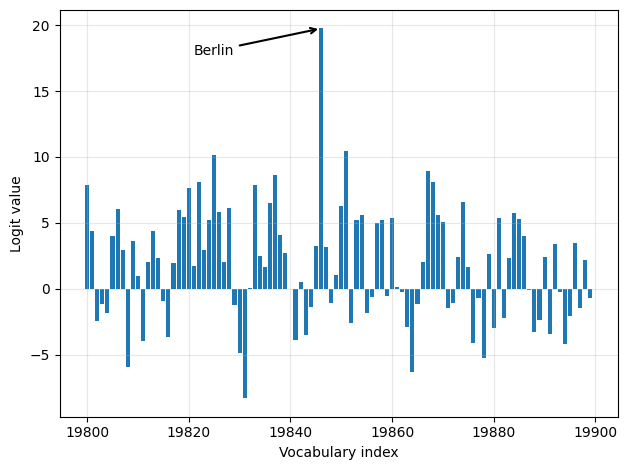

In [59]:
prompt = 'The capital of Germany is'
input_ids = torch.tensor(tokenizer.encode(prompt), device = device).unsqueeze(0)
with torch.inference_mode():
    next_token_logits = model(input_ids)[:, -1]

plot_scores_bar(next_token_logits)

In [46]:
def scale_logits_with_temperature(logits, temperature):
    if temperature < 0:
        raise ValueError('Temperature must be non-negative')
    return logits/temperature


In [48]:
def plot_logits_with_temperature(
    next_token_logits, start=19_800, end=19_900,
    temps=(0.5, 5.0),
):
    x = torch.arange(start, end)
    logits_orig = next_token_logits[0, start:end].float().cpu()
    logits_scaled = [  
        scale_logits_with_temperature(logits_orig, T) for T in temps  
    ]  
    plt.plot(x, logits_orig, label="Original logits", lw=2)  
    plt.plot(  
        x, logits_scaled[0],  
        label=f"T={temps[0]} (sharper)", ls="--", lw=1  
    )  
    plt.plot(  
        x, logits_scaled[1],  
        label=f"T={temps[1]} (flatter)", ls=":", lw=3  
    )  
    # Highlight max logit
    max_idx = torch.argmax(logits_orig)  
    plt.annotate(  
        "Berlin",
        xy=(x[max_idx], logits_orig[max_idx]),
        xytext=(x[max_idx] - 25, logits_orig[max_idx] + 2),
        arrowprops={"facecolor": "black", "arrowstyle": "->", "lw": 1.5},
        fontsize=12,
    )
    plt.xlabel("Vocabulary index")
    plt.ylabel("Logit value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

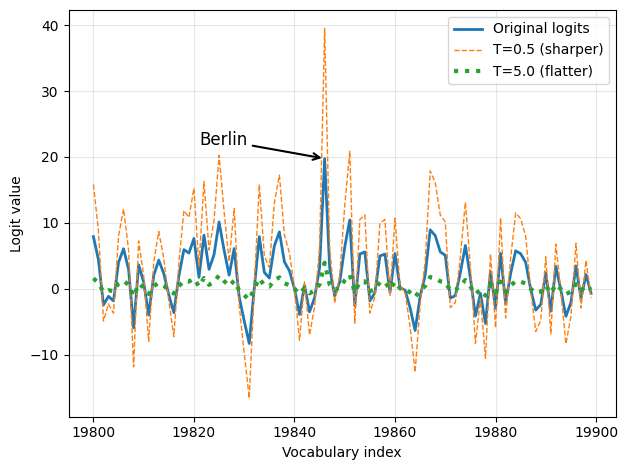

In [49]:
plot_logits_with_temperature(next_token_logits)

In [76]:
#same for probabilities
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits.float(), dim=-1)

In [74]:
next_token_logits

tensor([[ 8.8750, 10.6250,  8.6250,  ..., -2.2500, -2.2500, -2.2500]],
       dtype=torch.bfloat16)

In [98]:
next_token_probas = softmax_with_temperature(next_token_logits, 0.5)
next_token_probas.sum()

tensor(1.0000)

In [99]:
torch.manual_seed(123)
selected_token_id = torch.multinomial(next_token_probas.cpu(), num_samples=1)
print(selected_token_id)
selected_token = tokenizer.decode([selected_token_id])
print(f'Sampled token: {selected_token}')

tensor([[1304]])
Sampled token:  __


We can run the sampling multiple times and see how many times a token is selected

In [ ]:
def count_samples(probas, num_samples=1000, threshold=1, tokenizer=None):
    samples = torch.multinomial( 
        probas.cpu(), num_samples=num_samples, replacement=True #replacement=True allows to select the same sample multiple times
    )
    counts = torch.bincount(samples.squeeze(0), minlength=1) #counts how many times an index is selected
    for i, c in enumerate(counts):
        if c > threshold: #C
            if tokenizer is None:
                print(f"Vocab index {i}: {c.item()}x")
            else:
                print(f"'{tokenizer.decode([i])}': {c.item()}x")

In [105]:
torch.manual_seed(123)
next_token_probas = softmax_with_temperature(next_token_logits, 0.35)
count_samples(next_token_probas, tokenizer=tokenizer)

'
': 2x
' __': 187x
' ___': 3x
' Berlin': 417x
' ____': 168x
' ______': 197x
' Munich': 4x
' Hamburg': 3x
' _____': 17x


In [106]:
from reasoning_from_scratch.qwen3 import KVCache

In [111]:
#now we can add temeprature sampling to generate_text function
@torch.inference_mode()
def generate_text_temp_stream_cache(model, token_ids, max_new_tokens, eos_token_id = None, temperature = 0):
    model.eval()
    cache = KVCache(n_layers=model.cfg["n_layers"])
    model.reset_kv_cache()

    next_token_logits = model(token_ids, cache=cache)[:, -1]

    orig_device = token_ids.device

    for _ in range(max_new_tokens):
        
        if temperature is None or temperature <= 0:
            next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        else:
            next_token_probas = softmax_with_temperature(next_token_logits, temperature=temperature)
            next_token_id = torch.multinomial(next_token_probas.cpu(), num_samples=1)
            next_token_id = next_token_id.to(orig_device)
        
        if eos_token_id is not None and next_token_id.item() == eos_token_id:
                break
        
        yield next_token_id
        next_token_logits = model(next_token_id, cache=cache)[:, -1]

In [109]:
raw_prompt = """ 
Half the value of $3x-9$ is $x+37$. 
What is the value of $x$?
"""

prompt = render_prompt(raw_prompt)

In [114]:
torch.manual_seed(123)
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_temp_stream_cache, 
    temperature=1.1,
)


  {Question: half the value of $3x-9$ is $x+37$. What is the value of $x?$}
Half the value of $3x - 9$ is $x + 37$. 

First, calculate half of $(3x - 9)$:
$\frac{1}{2}(3x - 9) = x + 37$.

Expanding the left part, we get:
$\frac{3x}{2} - \frac{9}{2} = x + 37$.

Add $\frac{9}{2}$ to both sides:
$\frac{3x}{2} = x + \frac{9}{2} + 37$.

Combine the constant terms on the right side:
$\frac{3x}{2} = x + \frac{85}{2}$.

Subtract $x$ and add both sides with $\frac{9}{2}$:
$\frac{3x}{2} - x = \frac{85}{2}$.

Convert to like terms:
$\left(\bcancel{\left(\frac{3}{2} - \frac{4}{2}\right)}x\right) = \bcancel{\frac{85}{2} - 20}$.

Final step: simplify to find $x$:
$x - 20 = -20$.

$x = \boxed{-20}$.
ALL THIS CRED טבע denne plaginen må ikke endrede!

Now we can add also TOP-P SAPLING FILTER to avoid strange tokens (low probability) to be picked

In [125]:
def sample_with_temperature_and_top_p(next_token_logits, orig_device, temperature=1, top_p=0.9):
    next_token_probas = softmax_with_temperature(next_token_logits, temperature=temperature)
    sorted_probas, sorted_ids = torch.sort(next_token_probas, descending=True)
    cumsum = torch.cumsum(sorted_probas, dim=-1)
    mask = cumsum <= top_p
    mask[:, 0] = True #fallback to keep only the first token if top_p <= 0
    
    sorted_probas_filtered = sorted_probas[mask]
    sorted_ids_filtered = sorted_ids[mask]


    sorted_probas_filtered_rescaled = sorted_probas_filtered / sorted_probas_filtered.sum()

    next_token_id = sorted_ids_filtered[torch.multinomial(sorted_probas_filtered_rescaled.cpu(), num_samples=1)]
    next_token_id = next_token_id.unsqueeze(0).to(orig_device)

    return next_token_id

In [126]:
@torch.inference_mode()
def generate_text_temp_and_top_p_stream_cache(model, token_ids, max_new_tokens, eos_token_id = None, temperature = 0, top_p = 0.9):
    model.eval()
    cache = KVCache(n_layers=model.cfg["n_layers"])
    model.reset_kv_cache()

    next_token_logits = model(token_ids, cache=cache)[:, -1]

    orig_device = token_ids.device

    for _ in range(max_new_tokens):
        if temperature is None or temperature <= 0:
            next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        else:
            next_token_id = sample_with_temperature_and_top_p(next_token_logits, orig_device, temperature, top_p)
        
        if eos_token_id is not None and next_token_id.item() == eos_token_id:
            break
            
        yield next_token_id
        next_token_logits = model(next_token_id, cache=cache)[:, -1]

In [122]:
# let's see the difference

torch.manual_seed(123)
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_temp_stream_cache, 
    temperature=1.1,
)

  {Question: half the value of $3x-9$ is $x+37$. What is the value of $x?$}
Half the value of $3x - 9$ is $x + 37$. 

First, calculate half of $(3x - 9)$:
$\frac{1}{2}(3x - 9) = x + 37$.

Expanding the left part, we get:
$\frac{3x}{2} - \frac{9}{2} = x + 37$.

Add $\frac{9}{2}$ to both sides:
$\frac{3x}{2} = x + \frac{9}{2} + 37$.

Combine the constant terms on the right side:
$\frac{3x}{2} = x + \frac{85}{2}$.

Subtract $x$ and add both sides with $\frac{9}{2}$:
$\frac{3x}{2} - x = \frac{85}{2}$.

Convert to like terms:
$\left(\bcancel{\left(\frac{3}{2} - \frac{4}{2}\right)}x\right) = \bcancel{\frac{85}{2} - 20}$.

Final step: simplify to find $x$:
$x - 20 = -20$.

$x = \boxed{-20}$.
ALL THIS CRED טבע denne plaginen må ikke endrede!

In [127]:
# let's see the difference

torch.manual_seed(123)
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_temp_and_top_p_stream_cache, 
    temperature=1.1,
    top_p=0.8   
)

 \boxed{24}

In [128]:
from reasoning_from_scratch.ch03 import extract_final_candidate
from collections import Counter

In [ ]:
def self_consinstency_vote(model, tokenizer, prompt, device,
num_samples=10, temperature=0.8, top_p=0.9, max_new_tokens=2048,
show_progress=True, show_long_answer=False, seed=None):
    full_answers, short_answers = [], []

    for i in range(num_samples):

        if seed is not None:
            torch.manual_seed(seed + i + 1)

        answer = generate_text_stream_concat_flex(
            model, tokenizer, prompt, device,
            max_new_tokens=max_new_tokens, verbose=show_long_answer,
            generate_func=generate_text_temp_and_top_p_stream_cache, 
            temperature=temperature,
            top_p=top_p   
        )

        full_answers.append(answer)
        short_answer = extract_final_candidate(answer)
        short_answers.append(short_answer)

        if show_progress:
            print(f'Sample {i+1}/{num_samples} --> {short_answer!r}')
        
        # Early stopping: if one answer has majority, stop
        counts = Counter(short_answers)
        max_count = counts.most_common(1)[0][1] if counts else 0
        if max_count > num_samples / 2:
            if show_progress:
                print(f"Early stopping: '{short_answer}' has majority ({max_count}/{i+1})")
            break
    
    # Final counting and analysis
    counts = Counter(short_answers)
    
    groups = {s: [] for s in counts}
    for idx, s in enumerate(short_answers):
        groups[s].append(idx)
    
    most_common = counts.most_common()
    if not most_common:
        majority_winners, final_answer = [], None
    else:
        top_freq = most_common[0][1]
        majority_winners = [s for s, f in most_common if f == top_freq]
        final_answer = most_common[0][0] if len(majority_winners) == 1 else None
    
    return {
        "full_answers": full_answers,
        "short_answers": short_answers,
        "counts": dict(counts),
        "groups": groups,
        "majority_winners": majority_winners,
        "final_answer": final_answer,
        }


In [134]:
result = self_consinstency_vote(
    model,
    tokenizer,
    prompt,
    device=device,
    num_samples=5,
    temperature=0.8,
    top_p=0.9,
    max_new_tokens=2048,
    seed=123,
    show_progress=True,
)

Sample 1/5 --> ''
Sample 2/5 --> '83'
Sample 3/5 --> '83'
Sample 4/5 --> '36'
Sample 5/5 --> '33'


In [135]:
final_anser = result['final_answer']
print(final_anser)

83


In [136]:
explanation = result['full_answers'][2]
print(explanation)

 To solve the problem, let's break it down step by step.

**Given:**
Half the value of \( 3x - 9 \) is \( x + 37 \).

**Step 1: Translate the statement into an equation.**

Half of \( 3x - 9 \) is equal to \( x + 37 \). This can be written as:
\[
\frac{1}{2}(3x - 9) = x + 37
\]

**Step 2: Eliminate the fraction by multiplying both sides by 2.**
\[
2 \times \frac{1}{2}(3x - 9) = 2(x + 37)
\]
\[
3x - 9 = 2x + 74
\]

**Step 3: Solve for \( x \).**

Subtract \( 2x \) from both sides:
\[
3x - 2x - 9 = 74
\]
\[
x - 9 = 74
\]

Add 9 to both sides:
\[
x = 74 + 9
\]
\[
x = 83
\]

**Final Answer:**
\[
\boxed{83}
\]


In [137]:
result['full_answers']

['',
 " To solve the problem, let's follow the steps carefully.\n\n**Given:**\n- Half the value of \\( 3x - 9 \\) is \\( x + 37 \\).\n\n**Step 1: Translate the given information into an equation.**\n\nHalf of \\( 3x - 9 \\) is \\( \\frac{1}{2}(3x - 9) \\). According to the problem, this is equal to \\( x + 37 \\).\n\nSo, the equation becomes:\n\\[\n\\frac{1}{2}(3x - 9) = x + 37\n\\]\n\n**Step 2: Eliminate the fraction by multiplying both sides by 2.**\n\\[\n2 \\times \\frac{1}{2}(3x - 9) = 2(x + 37)\n\\]\n\\[\n3x - 9 = 2x + 74\n\\]\n\n**Step 3: Subtract \\( 2x \\) from both sides to get all \\( x \\)-terms on one side.**\n\\[\n3x - 2x - 9 = 74\n\\]\n\\[\nx - 9 = 74\n\\]\n\n**Step 4: Add 9 to both sides to solve for \\( x \\).**\n\\[\nx = 74 + 9\n\\]\n\\[\nx = 83\n\\]\n\n**Final Answer:**\n\\[\n\\boxed{83}\n\\]",
 " To solve the problem, let's break it down step by step.\n\n**Given:**\nHalf the value of \\( 3x - 9 \\) is \\( x + 37 \\).\n\n**Step 1: Translate the statement into an equat

If there are some ties for the most frequent answer, 'final_anwer' will be None in this implementation. To address this, we will implement a tie-breaker based on the confidence of the majority winners

Let's combine CoT with Self-Consistency --> SCCoT

In [139]:
prompt_CoT = prompt + '\n\nSolve the problem and Explain step by step'

In [140]:
result = self_consinstency_vote(
    model,
    tokenizer,
    prompt_CoT,
    device=device,
    num_samples=5,
    temperature=0.8,
    top_p=0.9,
    max_new_tokens=2048,
    seed=123,
    show_progress=True,
)

Sample 1/5 --> ' how you arrived at the answer.'
Sample 2/5 --> '83'
Sample 3/5 --> '.'
Sample 4/5 --> '83'
Sample 5/5 --> '83'
